In [1]:
import time
import urllib3
import random
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
headers = {}
headers['User-Agent'] = "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"    
http = urllib3.PoolManager()

In [4]:
df = pd.DataFrame()

# scrapper da página da Câmara
for page in tqdm(range(1, 23)):
    url = 'http://www.camara.gov.br/internet/sileg/Prop_lista.asp?Pagina='+str(page)+'&Autor=5310721&Limite=N'
    response = http.request(method='GET', url=url, headers=headers)
    soup = BeautifulSoup(response.data)

    for td in range(len(soup.find_all('td'))):
        for p in range(len(soup.find_all('td')[td])):
            try:
                if p == 0:
                    df.loc[int(str(page)+str(td)), 'autores'] = soup.find_all('td')[td].find_all('p')[p].text
                elif p == 1:
                    df.loc[int(str(page)+str(td)), 'data de apresentação e ementa'] = soup.find_all('td')[td].find_all('p')[p].text
            except:
                pass
    # para não kickarem por requisições demais:
    time.sleep(3)
    
# resetar o índice:
df = df.reset_index(drop=True)

# parsear a data de apresentação
df['data de apresentação'] = df['data de apresentação e ementa'].str.extract(r'([0-9]{1,2}/[0-9]{1,2}/[0-9]{4})')

# parsear a ementa
for line in range(len(df)):
    df.loc[line, 'ementa'] = df.loc[line, 'data de apresentação e ementa'].split(df.loc[line, 'data de apresentação'])[1]
df['ementa'] = df['ementa'].str.replace('Ementa: ', '')

# arrumar os autores
df['autores'] = df['autores'].str.replace('Autor: ', '')
df['autores'] = df['autores'].str.replace('Autores: ', '')

# deleta a coluna que tem a data de apresentação e ementa juntas
del df['data de apresentação e ementa']

100%|██████████| 22/22 [02:40<00:00,  7.63s/it]


In [15]:
df.to_csv('projetos_bolsonaro.csv', index=False, sep=';')

In [16]:
df = pd.read_csv('projetos_bolsonaro.csv', sep=';')

In [17]:
text = df['ementa'].str.cat(sep=' ')

In [88]:
stopwords = ['1', '1°', '2', '2°', '3', '3°', 'Altera', 'Bolsonaro', 'Decreto', 'Dep', 'II', 'INFORMAÇÕES', 'Jair',
             'Lei', 'Parecer', 'Relator', 'SOLICITA', 'Sugere', 'a', 'abril', 'agosto', 'ano', 'anos', 'ao', 'aos',
             'aprovação', 'art', 'artigo', 'as', 'bolsonaro', 'com', 'da', 'das', 'de', 'dep', 'dezembro', 'dia',
             'dispõe', 'do', 'dos', 'dá', 'em', 'fevereiro', 'inciso', 'jair', 'janeiro', 'julho', 'junho', 'MPV', 'maio',
             'março', 'n', 'na', 'nas', 'no', 'nos', 'nova', 'novembro', 'novo', 'n°', 'o', 'os', 'ou', 'outra',
             'outras', 'outro', 'outros', 'outubro', 'para', 'pela', 'pelas', 'pelo', 'pelos', 'por', 'que', 'redação',
             'se', 'seja', 'setembro', 'seu', 'sobre', 'sua']

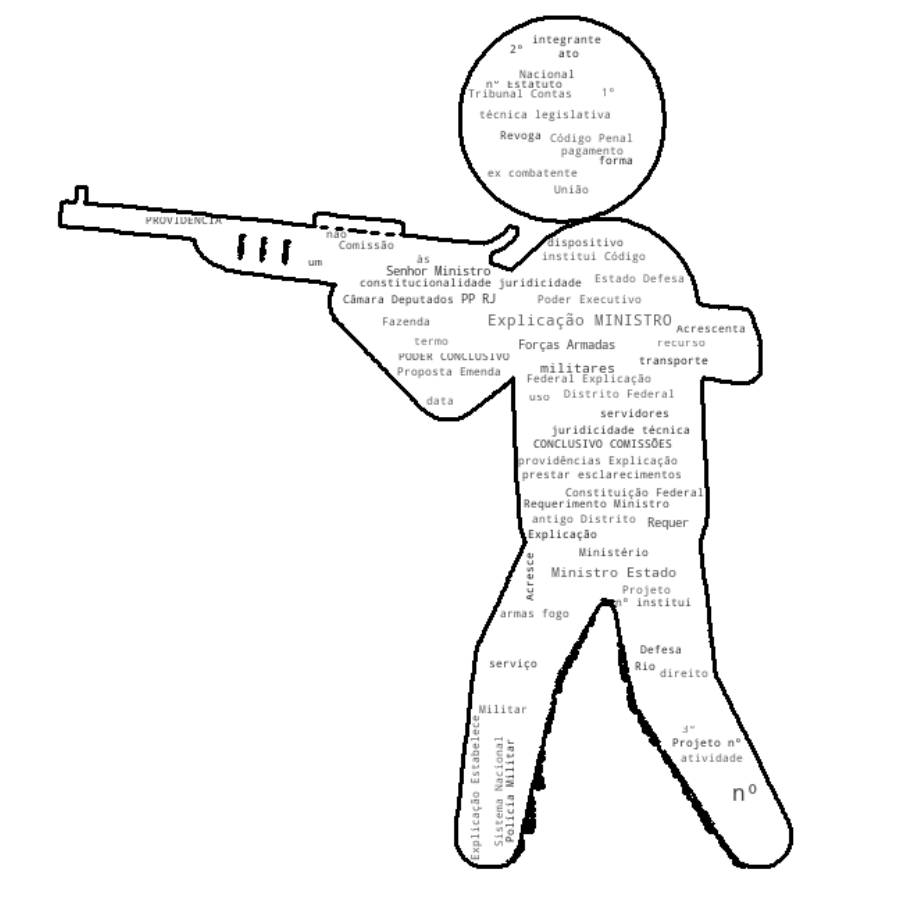

In [89]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 40)

arma_mask = np.array(Image.open('criminal_mask.png'))

# Gera a nuvem de palavras
wordcloud = WordCloud(background_color='white',
                      max_words=2000,
                      contour_width=2,
                      contour_color='black',
                      max_font_size=16,
                      min_font_size=8,
                      mask=arma_mask,
                      stopwords=stopwords,
                      width=1600,
                      height=800).generate(text)

# mostra a nuvem com matplotlib
plt.figure(figsize=(16,16))
default_colors = wordcloud.to_array()
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')

wordcloud.to_file('wc.png');